# DTSA-5510 Final Project
Author: Alan Klein

Create Date: 2025-04-27

github link: https://github.com/Saganoky/DTSA-5510-Final-Project

## Introduction

This code will be analyzing heart disease data with the goal of identifying similar patients within the data. Unsupervised learning techniques will be used. This is important as different patients will respond better to different treatments.  By grouping these patients together health care providers can better triage and provider better care for their patients.  For successful treatment of similar patients in the past can be used as a guide for future patients.


## Setup
The code below imports all the required packages.  This repo uses UV for package management, see https://docs.astral.sh/uv/ for more information.  If you are not familiar with UV I highly recommend you check it out. It fast and easy to use. Additionally, it is being used more and more in industry.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from kaggle.api.kaggle_api_extended import KaggleApi

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import NMF, PCA
from sklearn.cluster import  KMeans


## Exploratory Data Analysis (EDA)

This data comes from a Kaggle competition located [here](https://www.kaggle.com/competitions/k-means-clustering-for-heart-disease-analysis) [1].  The first step in EDA is to read any documentation about the dataset from the source.

It consists of a set of anonymized patients all who have a diagnosis of heart disease.  Each row represents one of these patients and their various attributes.  On the Kaggle page is has the following schema information.  Looks like there is a mix of discrete and categorical variables.  These will need to be transformed for many of the unsupervised techniques to work.

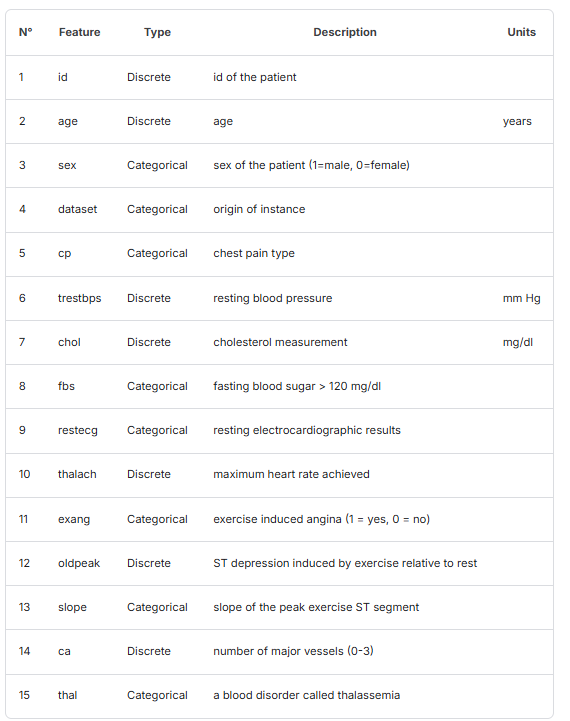

In [ ]:
# This sets up the Kaggle API.  You need to have a Kaggle account and a token to be able to run this code.  
# This video gives a pretty good explanation of how to get the token: https://www.youtube.com/watch?v=gkEbaMgvLs8&t=188s
api = KaggleApi()
api.authenticate()

In [ ]:
# Run these two commands to download and unzip the data sets into the data folder.  Note that the data folder and zip file 
# are gitignored.  And the below code is commented out so that it doesn't run every time you run the notebook.

# !kaggle competitions download -c k-means-clustering-for-heart-disease-analysis
# !unzip k-means-clustering-for-heart-disease-analysis -d data/

Archive:  k-means-clustering-for-heart-disease-analysis.zip
  inflating: data/heart_disease.csv  
  inflating: data/sample.csv         


In [78]:
# Read in the data as dataframe
data = pd.read_csv('data/heart_disease.csv')
sample_submission = pd.read_csv('data/sample.csv')

In [ ]:
# Check the first few rows of the data
print(data.head())

# Check basic info
data.info()

# Based on the first look the data will need a bit of work before its ready for analysis.  There are a number of missing values which will have to be dealt with.
# There are also a number of categorical variables that will need to be encoded.  Additionally, many of the variables seem to come from exercise tests and are 
# likely to be correlated with each other.  Meaning it may be worth looking into PCA, feature engineering or some other dimensionality reduction technique to reduce 
# the number of variables. This is where I would do more domain research to understand the data better.  However, that is outside the scope of this project.
# Also note that the dataset isn't huge it only has 920 rows and 15 columns.

   id  age     sex    dataset               cp  trestbps   chol    fbs  \
0   0   63    Male  Cleveland   typical angina     145.0  233.0   True   
1   1   67    Male  Cleveland     asymptomatic     160.0  286.0  False   
2   2   67    Male  Cleveland     asymptomatic     120.0  229.0  False   
3   3   37    Male  Cleveland      non-anginal     130.0  250.0  False   
4   4   41  Female  Cleveland  atypical angina     130.0  204.0  False   

          restecg  thalch  exang  oldpeak        slope   ca               thal  
0  lv hypertrophy   150.0  False      2.3  downsloping  0.0       fixed defect  
1  lv hypertrophy   108.0   True      1.5         flat  3.0             normal  
2  lv hypertrophy   129.0   True      2.6         flat  2.0  reversable defect  
3          normal   187.0  False      3.5  downsloping  0.0             normal  
4  lv hypertrophy   172.0  False      1.4    upsloping  0.0             normal  
0    0.0
Name: oldpeak, dtype: float64
<class 'pandas.core.frame.Data

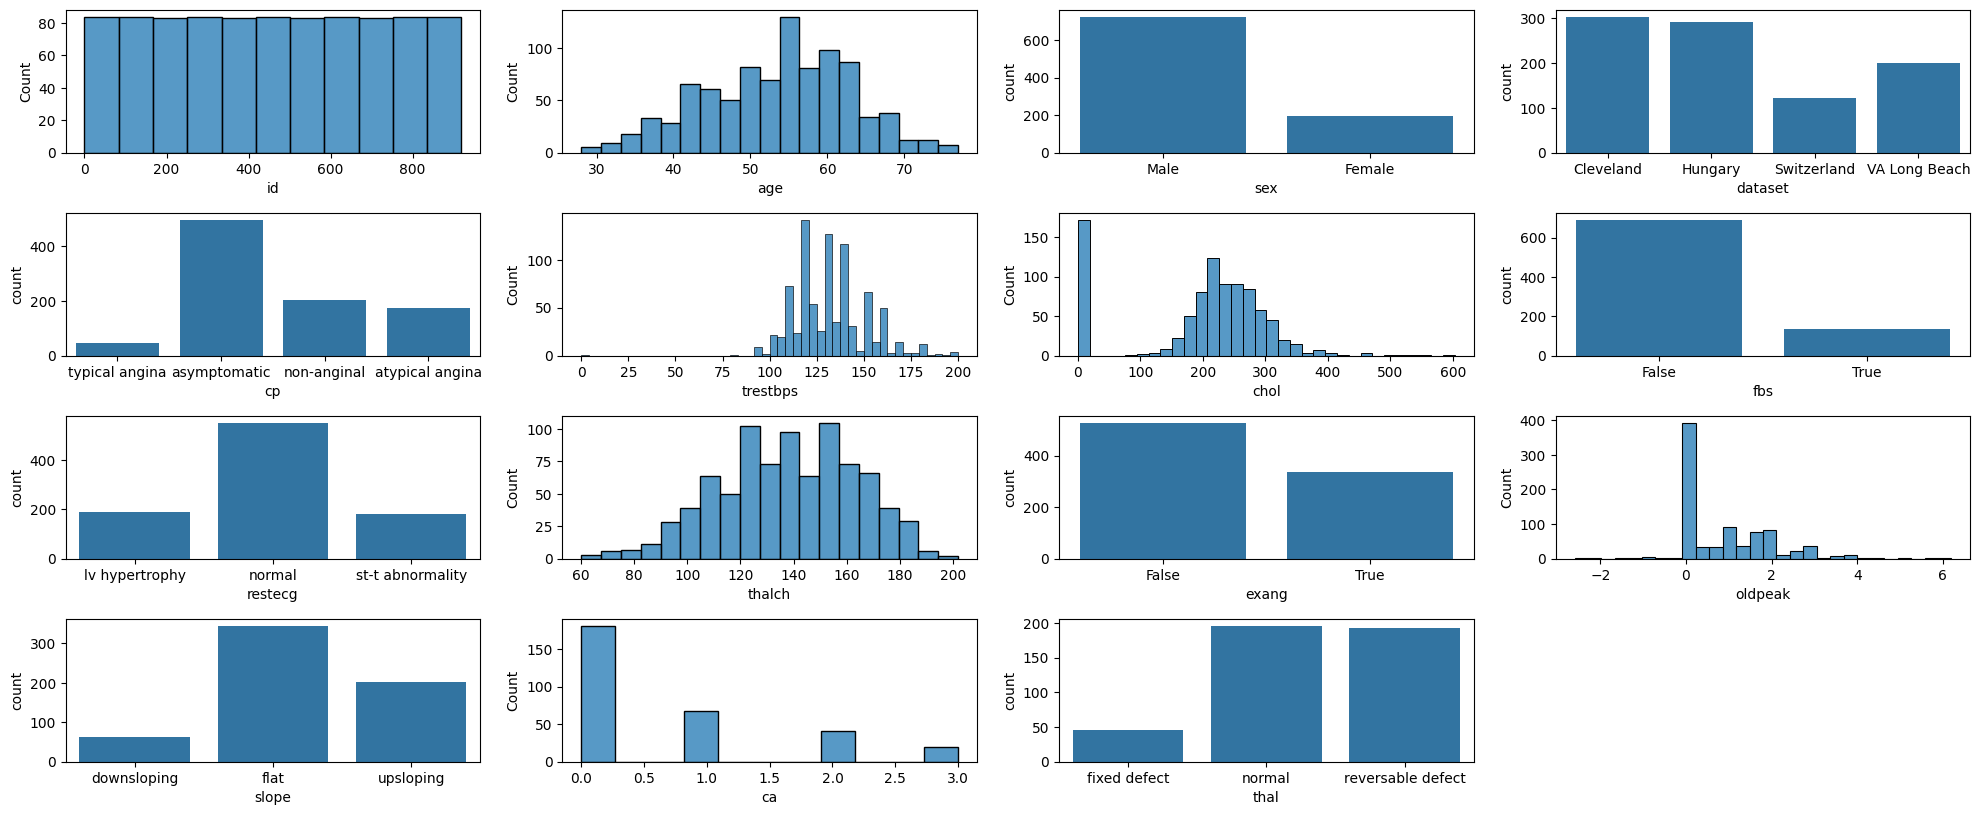

In [ ]:
def print_distribution_plots(data):
    """
    Plots the distribution of each column.
    """
    plt.figure(figsize=(20, 20))
    for i, col in enumerate(data.columns):
        plt.subplot(10,4,i+1)
        if data[col].dtype == 'object':
            sns.countplot(data, x=col)
        if data[col].dtype == 'int64':
            sns.histplot(data, x=col)
        if data[col].dtype == 'float64':
            sns.histplot(data, x=col)
    plt.tight_layout()
    plt.show()

print_distribution_plots(data)

# After looking at the distribution plots, a few interesting things stand out:
# 1. Some of the data is imbalanced such as male/female
# 2. chol is a cholesterol level, however, many of the values are 0. This is likely a missing value.
# 3. ca can only have values of 0, 1, 2, or 3.  Most likely this should be imputed as 0. Domain knowledge would be needed to know for sure.
# 4. oldpeak has most of its values at 0.  Will impute missing values as 0.
# 5. Will add a value of missing data to all the categorical variables.  My theory is that the fact that certain tests were not done is important information. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  920 non-null    float64
 6   chol      920 non-null    float64
 7   fbs       920 non-null    object 
 8   restecg   920 non-null    object 
 9   thalch    920 non-null    float64
 10  exang     920 non-null    object 
 11  oldpeak   920 non-null    float64
 12  slope     920 non-null    object 
 13  ca        920 non-null    float64
 14  thal      920 non-null    object 
dtypes: float64(5), int64(2), object(8)
memory usage: 107.9+ KB
None


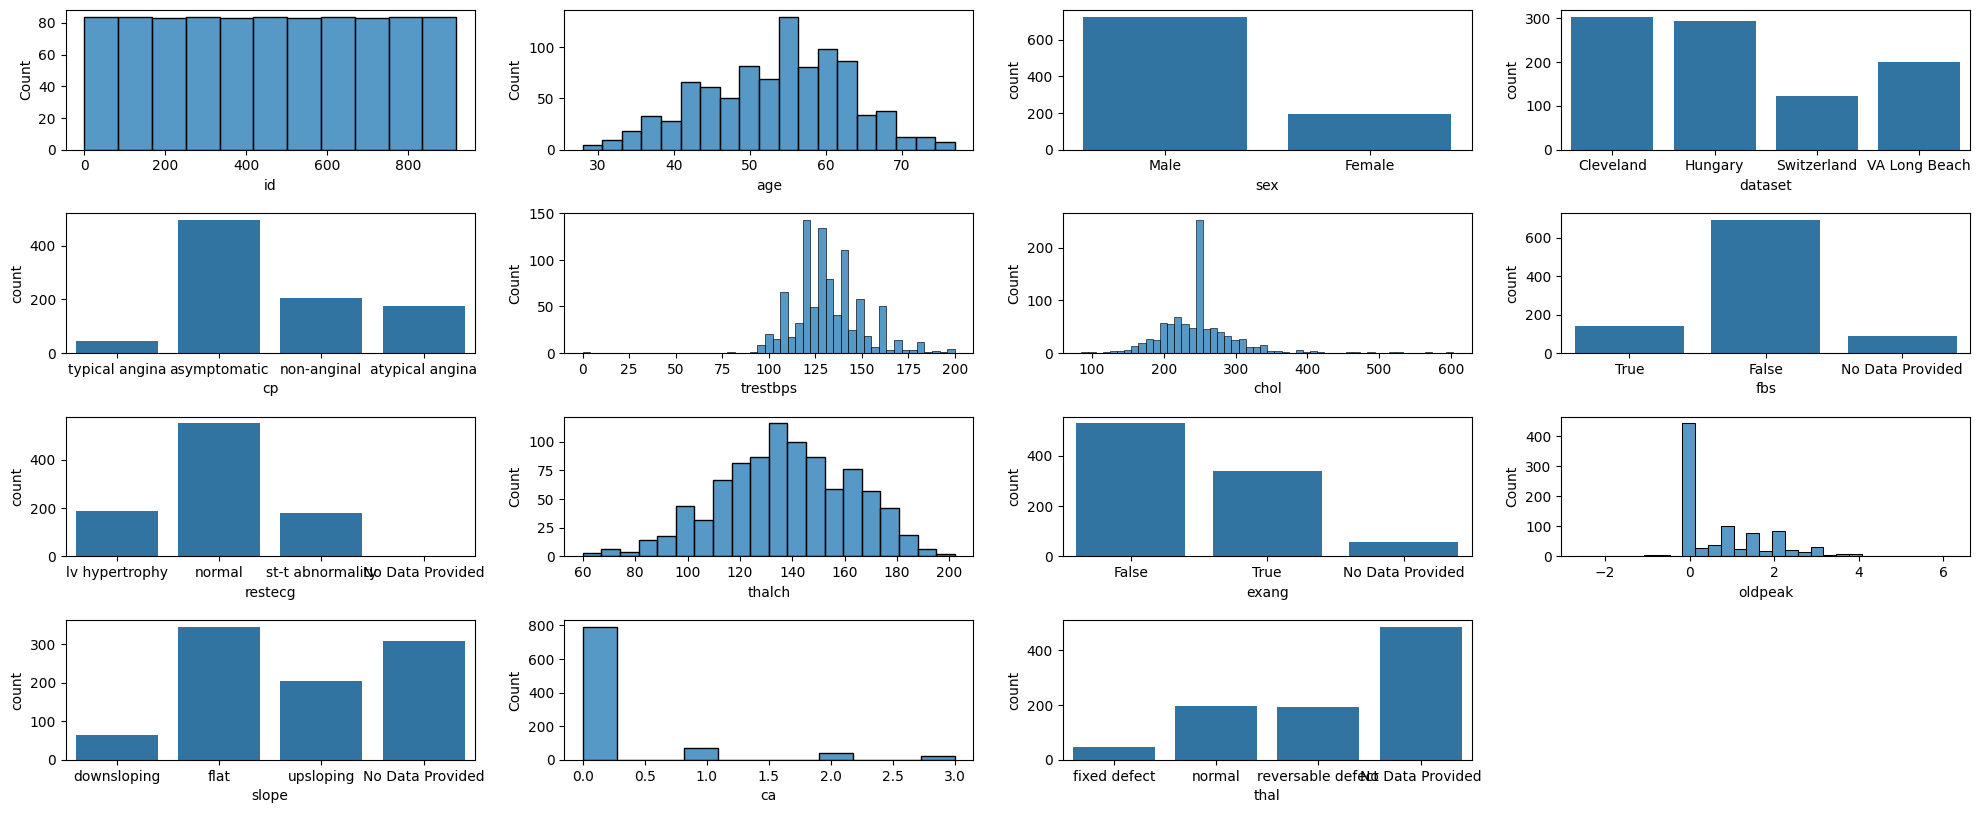

In [ ]:
# Fixing missing values

def fix_missing_values(data):
    """
    Fixes missing values in the data.
    """
    imputed_data = data.copy()
    imputed_data['trestbps'] = imputed_data['trestbps'].fillna(imputed_data['trestbps'].mean())
    imputed_data['chol'] = imputed_data['chol'].replace(0,np.nan)
    imputed_data['chol'] = imputed_data['chol'].fillna(imputed_data['chol'].mean())
    imputed_data['fbs'] = imputed_data['fbs'].replace(True,'True')
    imputed_data['fbs'] = imputed_data['fbs'].replace(False,'False')
    imputed_data['fbs'] = imputed_data['fbs'].fillna('No Data Provided')
    imputed_data['restecg'] = imputed_data['restecg'].fillna('normal')
    imputed_data['thalch'] = imputed_data['thalch'].fillna(imputed_data['thalch'].mean())
    imputed_data['exang'] = imputed_data['exang'].replace(True,'True')
    imputed_data['exang'] = imputed_data['exang'].replace(False,'False')
    imputed_data['exang'] = imputed_data['exang'].fillna('No Data Provided')
    imputed_data['oldpeak'] = imputed_data['oldpeak'].fillna(0.0)
    imputed_data['slope'] = imputed_data['slope'].fillna('No Data Provided')
    imputed_data['ca'] = imputed_data['ca'].fillna(0.0)
    imputed_data['thal'] = imputed_data['thal'].fillna('No Data Provided')
    return imputed_data

imputed_data = fix_missing_values(data)
print(imputed_data.info())
print_distribution_plots(imputed_data)

# Data looks much better now.  There are no more missing values.

In [42]:
# Next the categorical variables will need to be encoded.  Inspiration for code below found [here](https://www.geeksforgeeks.org/ml-one-hot-encoding/) [2]

def encode_categorical_variables(data, input_columns):
    """
    Encodes categorical variables in the data.
    """
    encoder = OneHotEncoder(sparse_output=False)
    encoded = encoder.fit_transform(data[input_columns])
    encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(input_columns))
    data_encoded = pd.concat([data, encoded_df], axis=1)
    data_encoded = data_encoded.drop(input_columns, axis=1)
    return data_encoded

categorical_columns = imputed_data.select_dtypes(include=['object']).columns.tolist()

encoded_data = encode_categorical_variables(imputed_data, categorical_columns)

print(encoded_data.head())
print(encoded_data.info())

# Data is looking good.  All the categorical variables have been encoded.

   id  age  trestbps   chol  thalch  oldpeak   ca  sex_Female  sex_Male  \
0   0   63     145.0  233.0   150.0      2.3  0.0         0.0       1.0   
1   1   67     160.0  286.0   108.0      1.5  3.0         0.0       1.0   
2   2   67     120.0  229.0   129.0      2.6  2.0         0.0       1.0   
3   3   37     130.0  250.0   187.0      3.5  0.0         0.0       1.0   
4   4   41     130.0  204.0   172.0      1.4  0.0         1.0       0.0   

   dataset_Cleveland  ...  exang_No Data Provided  exang_True  \
0                1.0  ...                     0.0         0.0   
1                1.0  ...                     0.0         1.0   
2                1.0  ...                     0.0         1.0   
3                1.0  ...                     0.0         0.0   
4                1.0  ...                     0.0         0.0   

   slope_No Data Provided  slope_downsloping  slope_flat  slope_upsloping  \
0                     0.0                1.0         0.0              0.0   
1   

[[ 1.00738556  0.69804099 -0.26772559 ...  4.35889894 -0.5203059
  -0.51355259]
 [ 1.43203377  1.51176059  0.75805266 ... -0.22941573  1.92194629
  -0.51355259]
 [ 1.43203377 -0.65815834 -0.34514281 ... -0.22941573 -0.5203059
   1.94722024]
 ...
 [ 0.15808914 -0.54966239 -0.46126865 ...  4.35889894 -0.5203059
  -0.51355259]
 [ 0.4765753   0.          2.67412901 ... -0.22941573 -0.5203059
  -0.51355259]
 [ 0.90122351 -0.65815834  0.13871485 ... -0.22941573 -0.5203059
  -0.51355259]]


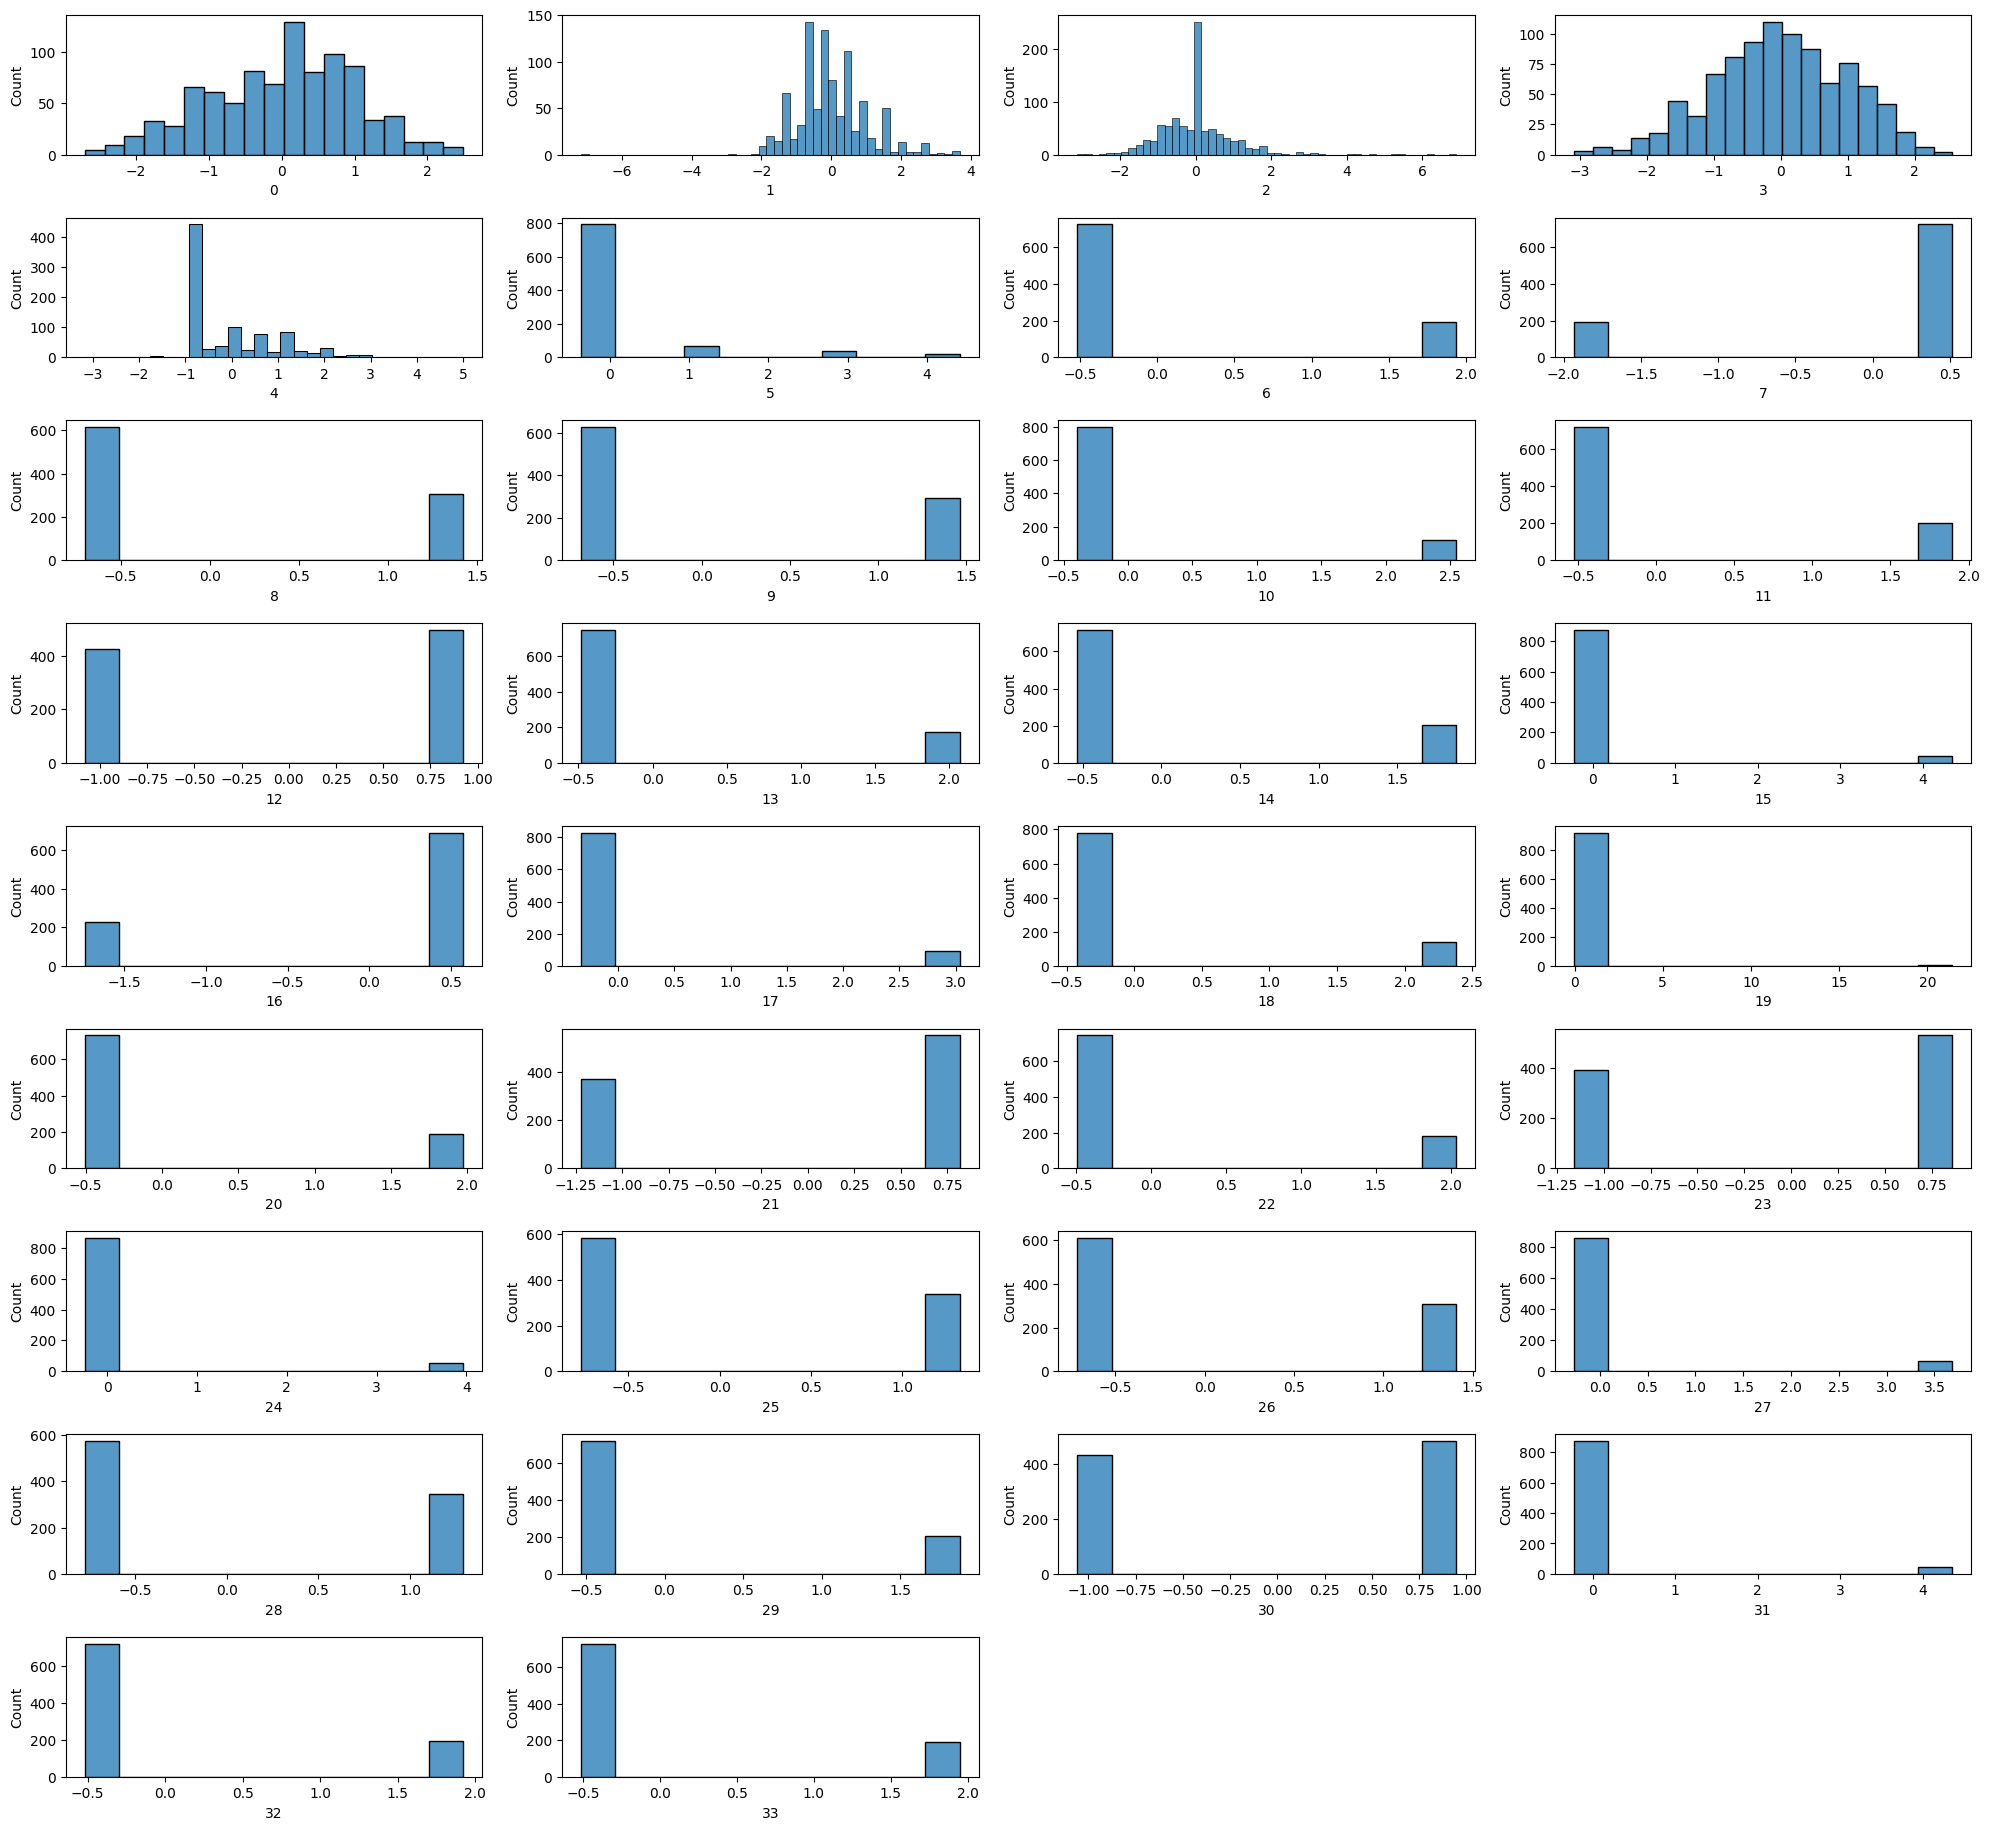

In [ ]:
# Next we will scale the data.

def scale_data(data):
    """
    Scales the data.
    """
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    return scaled_data

# we dont want to scale the id as it is not a feature
data_to_scale = encoded_data.drop(columns = ['id'])
scaled_data = scale_data(data_to_scale)

print_distribution_plots(pd.DataFrame(scaled_data))

# Somewhat hard to tell what column is which, but in general data looks good after scaling.

(920, 34)
[4.47505116e+00 4.45809273e+00 2.66086906e+00 2.36702086e+00
 1.85372730e+00 1.50608337e+00 1.38439576e+00 1.33203557e+00
 1.28226330e+00 1.13189385e+00 1.11183039e+00 1.08108527e+00
 1.04291003e+00 9.94201021e-01 9.65466990e-01 8.93173471e-01
 8.70842096e-01 8.36424447e-01 7.74091844e-01 7.12492242e-01
 6.25593871e-01 4.49494829e-01 4.06419296e-01 3.44718349e-01
 3.00188593e-01 1.76631043e-01 4.58318568e-16 4.44089210e-16
 6.26720734e-17 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]


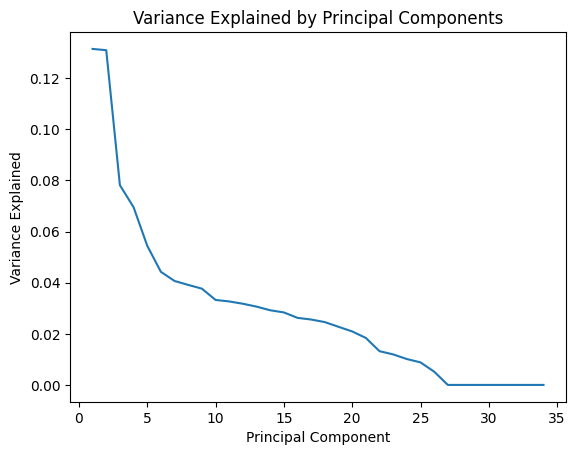

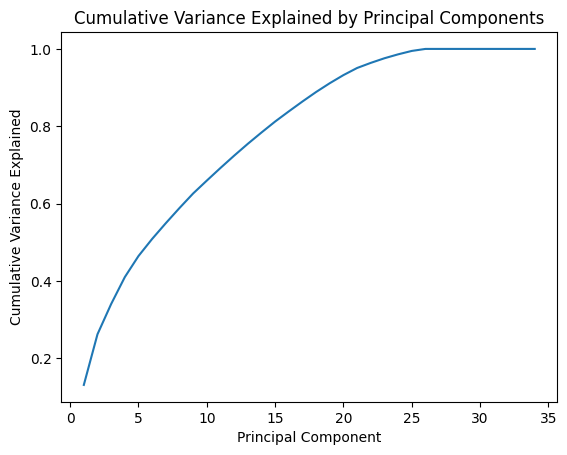

(920, 27)


In [ ]:
# Apply PCA to the data to remove correlation.  One downside of PCA is that it is hard to interpret the results.  Especially in the medical field this can be a problem.
#  However, since I'm trying to get a good score on the Kaggle competition, I will use PCA to reduce the number of features.
PCA_Model=PCA()
PCA_Data = PCA_Model.fit_transform(scaled_data)

print(PCA_Data.shape)
print(PCA_Model.explained_variance_)

sns.lineplot(x=range(1, PCA_Model.n_components_+1), y=PCA_Model.explained_variance_ratio_)
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.title('Variance Explained by Principal Components')
plt.show()

cumulated_variance = np.cumsum(PCA_Model.explained_variance_ratio_)
plt.plot(range(1, PCA_Model.n_components_+1), cumulated_variance)
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Variance Explained')
plt.title('Cumulative Variance Explained by Principal Components')
plt.show()

# The first 27 explain 99% of the variance.  So we will keep the first 27 components.
PCA_Data_Reduced = PCA_Data[:,:27]


## Analysis
I will try two approaches.  First I'll use k-means clustering.  The optimal number of clusters will be analyzed using the elbow method and distortion.  After that NMF will be applied to the data, as I don't have a good way to find the optimal number of clusters for NMF, I'll try a few variations and see the Kaggle results.

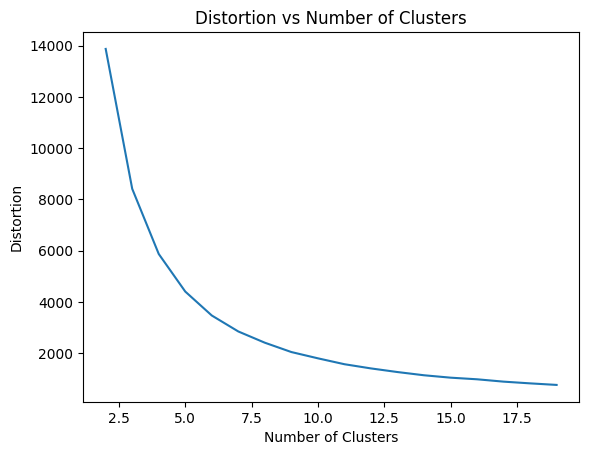

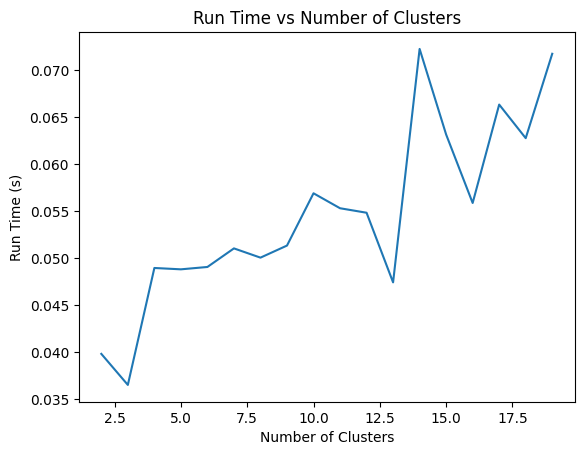

In [ ]:
#Kmeans Clustering

#initialize kmeans parameters
kmeans_kwargs = {
"init": "k-means++",
"n_init": 15,
"random_state": 1337,
}

def run_kmeans_model(data, number_of_clusters):
    """
    Runs the KMeans model on the data and returns the model and the run time.
    """
    #initialize kmeans parameters
    kmeans_kwargs = {
    "init": "k-means++",
    "n_init": 15,
    "random_state": 1337,
    }

    start = time.time()
    kmeans_model = KMeans(n_clusters=number_of_clusters, **kmeans_kwargs).fit(data)
    end = time.time()
    run_time = end - start
    return kmeans_model, run_time

# Run the KMeans model with 2 to 20 clusters and save the run time and inertia
distortion = []
run_times = []
clusters = []

for i in range(2, 20):
    kmeans_model, run_time = run_kmeans_model(PCA_Data_Reduced, i)
    distortion.append(kmeans_model.inertia_/i)
    run_times.append(run_time)
    clusters.append(i)

# Plot the inertia and run time
sns.lineplot(x=clusters, y=distortion)
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion')
plt.title('Distortion vs Number of Clusters')
plt.show()

sns.lineplot(x=clusters, y=run_times)
plt.xlabel('Number of Clusters')
plt.ylabel('Run Time (s)')
plt.title('Run Time vs Number of Clusters')
plt.show()
    
# Using the elbow method, it looks like the optimal number of clusters is between 6-8. I'll submit a few different models to Kaggle to see which one performs best.
# Run times are also incredibly fast, so even as they go up with number of clusters it hardly matters.

In [ ]:
# predict the clusters for 6, 7, and 8 clusters
kmeans_6_predict = KMeans(n_clusters=6).fit_predict(PCA_Data_Reduced)
kmeans_7_predict = KMeans(n_clusters=7).fit_predict(PCA_Data_Reduced)
kmeans_8_predict = KMeans(n_clusters=8).fit_predict(PCA_Data_Reduced)

# merge ids and predictions into a dataframe for submission
kmeans_6_submission = pd.DataFrame({'id': data['id'], 'cluster': kmeans_6_predict})
kmeans_7_submission = pd.DataFrame({'id': data['id'], 'cluster': kmeans_7_predict})
kmeans_8_submission = pd.DataFrame({'id': data['id'], 'cluster': kmeans_8_predict})

# Merge the sample submission with the predictions
kmeans_6_submission = pd.merge(sample_submission['id'], kmeans_6_submission, on='id')
kmeans_7_submission = pd.merge(sample_submission['id'], kmeans_7_submission, on='id')
kmeans_8_submission = pd.merge(sample_submission['id'], kmeans_8_submission, on='id')

# Save the submissions to csv files
kmeans_6_submission.to_csv('data/KMeans_6_Submission.csv', index=False)
kmeans_7_submission.to_csv('data/KMeans_7_Submission.csv', index=False)
kmeans_8_submission.to_csv('data/KMeans_8_Submission.csv', index=False)



In [ ]:
# Use this to submit the file to Kaggle.
# !kaggle competitions submit -c k-means-clustering-for-heart-disease-analysis -f data\KMeans_6_Submission.csv -m "K-means 6 clusters"
# !kaggle competitions submit -c k-means-clustering-for-heart-disease-analysis -f data\KMeans_7_Submission.csv -m "K-means 7 clusters"
# !kaggle competitions submit -c k-means-clustering-for-heart-disease-analysis -f data\KMeans_8_Submission.csv -m "K-means 8 clusters"

Successfully submitted to K-Means Clustering for Heart Disease Analysis



  0%|          | 0.00/2.01k [00:00<?, ?B/s]
100%|██████████| 2.01k/2.01k [00:00<00:00, 4.57kB/s]


Successfully submitted to K-Means Clustering for Heart Disease Analysis



  0%|          | 0.00/2.01k [00:00<?, ?B/s]
100%|██████████| 2.01k/2.01k [00:00<00:00, 4.72kB/s]


Successfully submitted to K-Means Clustering for Heart Disease Analysis



  0%|          | 0.00/2.01k [00:00<?, ?B/s]
100%|██████████| 2.01k/2.01k [00:00<00:00, 4.72kB/s]


In [ ]:
# Next lets try NMF.  In this case lets start with the encoded data as NMF requires non-negative data and scaling doesn't matter.

# Need to fix old peak to not have negative values.  adding minimum value to all values to make them positive.
encoded_data['oldpeak'] = encoded_data['oldpeak'] - encoded_data['oldpeak'].min()

def run_nmf_model(data, number_of_clusters):
    """
    Runs the NMF model on the data and returns the model and the run time.
    """
    start = time.time()
    nmf_model = NMF(n_components=number_of_clusters, random_state=1337, max_iter=10000)
    W = nmf_model.fit_transform(data)
    H = nmf_model.components_
    end = time.time()
    run_time = end - start
    return nmf_model, run_time, W, H

# Run the NMF model 3 times and submit the results to Kaggle.  As I don't have a good way to determine the optimal number of clusters, I will just try 3, 7, and 10 clusters.
nmf_model, run_time, W, H = run_nmf_model(encoded_data, 3)
nmf_pred_3 = np.argmax(W, axis = 1)

nmf_model, run_time, W, H = run_nmf_model(encoded_data, 7)
nmf_pred_7 = np.argmax(W, axis = 1)

nmf_model, run_time, W, H = run_nmf_model(encoded_data, 10)
nmf_pred_10 = np.argmax(W, axis = 1)

# merge ids and predictions into a dataframe for submission
nmf_3_submission = pd.DataFrame({'id': data['id'], 'cluster': nmf_pred_3})
nmf_7_submission = pd.DataFrame({'id': data['id'], 'cluster': nmf_pred_7})
nmf_10_submission = pd.DataFrame({'id': data['id'], 'cluster': nmf_pred_10})

# Merge the sample submission with the predictions
nmf_3_submission = pd.merge(sample_submission['id'], nmf_3_submission, on='id')
nmf_7_submission = pd.merge(sample_submission['id'], nmf_7_submission, on='id')
nmf_10_submission = pd.merge(sample_submission['id'], nmf_10_submission, on='id')

# Save the submissions to csv files
nmf_3_submission.to_csv('data/NMF_3_Submission.csv', index=False)
nmf_7_submission.to_csv('data/NMF_7_Submission.csv', index=False)
nmf_10_submission.to_csv('data/NMF_10_Submission.csv', index=False)



In [ ]:
# Use this to submit the file to Kaggle.
# !kaggle competitions submit -c k-means-clustering-for-heart-disease-analysis -f data/NMF_3_Submission.csv -m "K-means 3 clusters"
# !kaggle competitions submit -c k-means-clustering-for-heart-disease-analysis -f data/NMF_7_Submission.csv -m "K-means 7 clusters"
# !kaggle competitions submit -c k-means-clustering-for-heart-disease-analysis -f data/NMF_10_Submission.csv -m "K-means 10 clusters"

Successfully submitted to K-Means Clustering for Heart Disease Analysis



  0%|          | 0.00/2.01k [00:00<?, ?B/s]
100%|██████████| 2.01k/2.01k [00:00<00:00, 4.73kB/s]


Successfully submitted to K-Means Clustering for Heart Disease Analysis



  0%|          | 0.00/2.01k [00:00<?, ?B/s]
100%|██████████| 2.01k/2.01k [00:00<00:00, 5.17kB/s]


Successfully submitted to K-Means Clustering for Heart Disease Analysis



  0%|          | 0.00/2.01k [00:00<?, ?B/s]
100%|██████████| 2.01k/2.01k [00:00<00:00, 4.76kB/s]


## Result
Kaggle results are as follows:

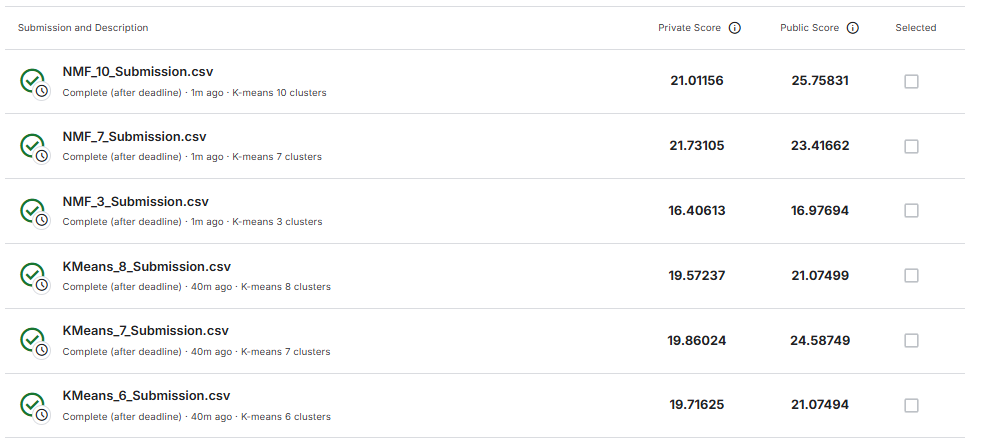

As you can see the 3 cluster NMF method performed the best. One thing to note is I had to increase the iterations on the NMF model for it to converge.  However, due to the small dataset, run time was not a factor in this analysis.

## Discussion
One of the main challenges of unsupervised learning is determining the correct number of clusters.  In this case I thought it would be between 6-8 based on the elbow method.  For that reason it surprised me that the 3 clusters of the NMF model performed the best in the Kaggle competition.  

This leads me to think that I need to understand how better to determine cluster numbers.  Two ideas come to mind.  One is to learn more about heart failure to try and better understand the different courses of treatment and when they are appropriate.  This may give me a sense of if 6+ clusters is just to many.  When conducting this analysis I also came across the idea of gap analysis[3].  This may be something to explore in the future.

Another avenue to explore with this type of analysis is to consider an ensemble model.  I could try and combine th two models together to see if I can get better results.  Additionally, I could run a few other models as well such as a hierarchical clustering method.

Finally, perhaps I should try running the kmeans model with 3 clusters and see how it performs.  It did better than NMF for 7 clusters, so maybe it would do better for 3.

## Conclusion
In conclusion, the clustering methods worked okay, the biggest challenge is determining the appropriate number of clusters.  This would be a good avenue of future research to see what methods are out there and if they would apply to this problem.

## References
[1] amirabwd18, Azzedine Idir Aitsaid, Mohcen Chouireb, and Omar Farouk Zouak. K-Means Clustering for Heart Disease Analysis. https://kaggle.com/competitions/k-means-clustering-for-heart-disease-analysis, 2023. Kaggle.
[2] GeeksforGeeks. (2025, February 7). One hot encoding in machine learning. GeeksforGeeks. https://www.geeksforgeeks.org/ml-one-hot-encoding/
[3] https://hastie.su.domains/Papers/gap.pdf